In [83]:
from importlib import reload
import numpy as np
import torch
import torch_geometric
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, fbeta_score
from torch.nn import functional as F

import data
reload(data)

<module 'data' from '/home/tomas/desktop/flib/thesis_XAML/data.py'>

In [84]:
class ClassBalancedLoss(torch.nn.Module):
    def __init__(self, beta, n_samples_per_classes, loss_type):
        super(ClassBalancedLoss, self).__init__()
        self.beta = beta
        self.effective_nums = 1.0 - np.power(beta, n_samples_per_classes)
        self.n_classes = len(n_samples_per_classes)
        self.loss_type = loss_type
    
    def forward(self, logits, labels):
        labels = labels.to(torch.int64)
        labels_one_hot = F.one_hot(labels, self.n_classes).float()
        weights = (1.0 - self.beta) / np.array(self.effective_nums)
        weights = weights / np.sum(weights) * self.n_classes
        weights = torch.tensor(weights, device=logits.device).float()
        weights = weights.unsqueeze(0)
        weights = weights.repeat(labels_one_hot.shape[0],1) * labels_one_hot
        weights = weights.sum(1)
        weights = weights.unsqueeze(1)
        weights = weights.repeat(1,self.n_classes)
        if self.loss_type == "sigmoid":
            loss = F.binary_cross_entropy_with_logits(input=logits,target=labels_one_hot,weight=weights)
        elif self.loss_type == "softmax":
            pred = logits.softmax(dim=1)
            loss = F.binary_cross_entropy(input=pred,target=labels_one_hot,weight=weights)
        else:
            raise ValueError("loss_type must be sigmoid or softmax")
        return loss

In [98]:
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        #x = self.log_softmax(x) #This is only needed when using NLLLoss, Classbalancedloss wants logits
        return x

# EarlyStopper code taken from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

class NLLLoss_recall80(nn.Module):
    def __init__(self, n_sar):
        super(NLLLoss_recall80, self).__init__()
        self.n_sar = n_sar
        
    def forward(self, input, target):
        l2 = torch.dot(input.exp()[:,1],target.float())/self.n_sar
        l1 = F.nll_loss(input, target)
        print(l2)
        print(self.n_sar)
        loss = l1 + l2
        return loss

def train_NeuralNetwork(hyperparameters = None, verbose = False):
    # Computing device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Data
    traindata = data.AmlsimDataset(node_file='data/simulation3/swedbank/train/nodes.csv', edge_file='data/simulation3/swedbank/train/edges.csv', node_features=True, node_labels=True).get_data()
    testdata = data.AmlsimDataset(node_file='data/simulation3/swedbank/test/nodes.csv', edge_file='data/simulation3/swedbank/test/edges.csv', node_features=True, node_labels=True).get_data()
    feature_names = ['sum','mean','median','std','max','min','in_degree','out_degree','n_unique_in','n_unique_out']
    target_names = ['not_sar','is_sar']
    
    # --- Add preprocessing here ---
    
    traindata = traindata.to(device)
    testdata = testdata.to(device)
    
    # Non-tunable hyperparameters
    input_size = traindata.x.shape[1]
    output_size = 2
    beta = 2 #Makes recall twice as important as precision
    
    # Tunable hyperparamters
    hidden_size = hyperparameters['hidden_size'] #10
    lr = hyperparameters['lr'] #0.005
    epochs = hyperparameters['epochs'] #400
    minority_class_weight = 1#2 #hyperparameters['minority_class_wieght'] #2
    
    class_weights = torch.tensor([1, minority_class_weight], dtype=torch.float32).to(device)
    
    # Model
    model = NeuralNetwork(input_size, hidden_size, output_size)
    model = model.to(device)
    
    # Criterion and optimizer
    #criterion = torch.nn.NLLLoss(weight=class_weights)
    # beta = 0.5
    # n_samples_per_classes = [(traindata.y == 0).sum().item(), (traindata.y == 1).sum().item()]
    # criterion = ClassBalancedLoss(beta=beta, n_samples_per_classes=n_samples_per_classes, loss_type='sigmoid')
    criterion = NLLLoss_recall80(n_sar=(traindata.y == 1).sum().item())
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Initialize early stopper
    early_stopper = EarlyStopper(patience=10, min_delta=0)
    first_stop = 0
    
    # Train model
    print(f'Starting training with {epochs} epochs.')
    # This model needs special input format, so we can't use the train_model function
    running_train_loss = []
    running_test_loss = []
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model.forward(traindata.x)
        loss = criterion(out, traindata.y)
        running_train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        #Evaluation
        model.eval()
        with torch.no_grad():
            out = model.forward(testdata.x)
            loss = criterion(out, testdata.y)
            running_test_loss.append(loss.item())
            accuracy = accuracy_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1))
            precision = precision_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
            recall = recall_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
            fbeta = fbeta_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), beta=beta, zero_division=0)
        if verbose and ((epoch+1)%10 == 0 or epoch == epochs-1):
                print(f'epoch: {epoch + 1}, train_loss: {running_train_loss[-1]:.4f}, test_loss: {running_test_loss[-1]:.4f}, accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, fbeta: {fbeta:.4f}')
        if early_stopper.early_stop(loss):
            if first_stop == 0:
                first_stop = epoch
            print(f'Stopping training early at {epoch}/{epochs} epochs.')             
            break
    print('Finished training.')
    
    return model, traindata, testdata, running_train_loss, running_test_loss, first_stop #accuracy

In [99]:
hyperparameters = {'hidden_size': 33,
                    'lr': 0.00005,
                    'epochs': 5000}

model, traindata, testdata, running_train_loss, running_test_loss, first_stop = train_NeuralNetwork(hyperparameters, verbose = True)

Using device: cuda


Starting training with 5000 epochs.
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
2173
tensor(nan, device='cuda:0')
2173
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
2173
tensor(nan, device='cuda:0')
2173
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
2173
tensor(nan, device='cuda:0')
2173
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
2173
tensor(nan, device='cuda:0')
2173
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
2173
tensor(nan, device='cuda:0')
2173
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
2173
tensor(nan, device='cuda:0')
2173
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
2173
tensor(nan, device='cuda:0')
2173
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
2173
tensor(nan, device='cuda:0')
2173
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
2173
tensor(nan, device='cuda:0')
2173
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
2173
tensor(nan, device='cuda:0')
2173
epoch: 10, train_loss: nan, test_loss: nan, 

KeyboardInterrupt: 

In [48]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
with torch.no_grad():
    out = model.forward(testdata.x)
    y_pred = out.cpu().numpy().argmax(axis=1)
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

[[3541  892]
 [ 300  135]]


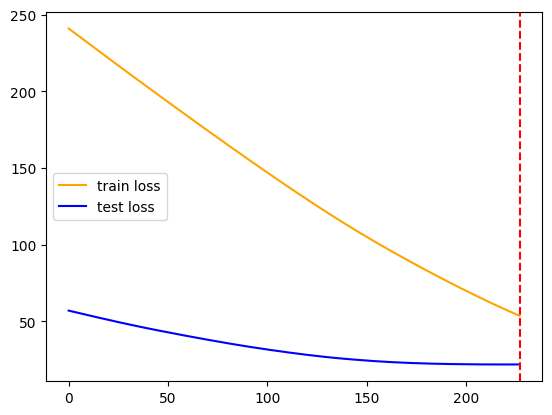

In [49]:
import matplotlib.pyplot as plt
plt.plot(running_train_loss, label='train loss', color='orange')
plt.plot(running_test_loss, label='test loss', color='blue')
plt.axvline(x=first_stop, color='red', linestyle='--')
plt.legend(['train loss', 'test loss'])
plt.show()

In [31]:
import optuna

def objective(trial):
    hyperparameters = {'hidden_size': trial.suggest_int('hidden_size', 10, 50),
                    'lr': trial.suggest_float('lr', 1e-6, 1e-3),
                    'epochs': trial.suggest_int('epochs', 300,500,step=50)}

    accuracy = train_NeuralNetwork(hyperparameters, verbose = False)
    return accuracy

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2024-03-28 10:30:57,511] A new study created in memory with name: no-name-b0ece63a-ce3f-412e-a749-4b8deeba49ec


Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:31:00,545] Trial 0 finished with value: 0.42953985209531637 and parameters: {'hidden_size': 44, 'lr': 0.000548763316374199, 'epochs': 300}. Best is trial 0 with value: 0.42953985209531637.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:31:04,576] Trial 1 finished with value: 0.533278553820871 and parameters: {'hidden_size': 24, 'lr': 0.0007925584627564088, 'epochs': 450}. Best is trial 1 with value: 0.533278553820871.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:31:07,763] Trial 2 finished with value: 0.4498767460969597 and parameters: {'hidden_size': 39, 'lr': 0.0006004563566718149, 'epochs': 350}. Best is trial 1 with value: 0.533278553820871.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:31:10,792] Trial 3 finished with value: 0.6548890714872637 and parameters: {'hidden_size': 29, 'lr': 0.000995087349245614, 'epochs': 300}. Best is trial 3 with value: 0.6548890714872637.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:31:13,827] Trial 4 finished with value: 0.731101068200493 and parameters: {'hidden_size': 38, 'lr': 0.000466425476769442, 'epochs': 300}. Best is trial 4 with value: 0.731101068200493.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:31:16,675] Trial 5 finished with value: 0.38783894823336074 and parameters: {'hidden_size': 41, 'lr': 0.0005610130279188441, 'epochs': 300}. Best is trial 4 with value: 0.731101068200493.


Finished training.
Using device: cuda
Starting training with 500 epochs.


[I 2024-03-28 10:31:21,601] Trial 6 finished with value: 0.4938373048479869 and parameters: {'hidden_size': 10, 'lr': 6.362779131982388e-05, 'epochs': 500}. Best is trial 4 with value: 0.731101068200493.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:31:25,209] Trial 7 finished with value: 0.4619967132292523 and parameters: {'hidden_size': 41, 'lr': 0.0003542843382159434, 'epochs': 400}. Best is trial 4 with value: 0.731101068200493.


Finished training.
Using device: cuda
Starting training with 500 epochs.


[I 2024-03-28 10:31:29,998] Trial 8 finished with value: 0.3769515201314708 and parameters: {'hidden_size': 49, 'lr': 0.00035446269485682426, 'epochs': 500}. Best is trial 4 with value: 0.731101068200493.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:31:34,406] Trial 9 finished with value: 0.19617912900575185 and parameters: {'hidden_size': 33, 'lr': 0.0005257957261934178, 'epochs': 450}. Best is trial 4 with value: 0.731101068200493.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:31:37,922] Trial 10 finished with value: 0.33627773212818407 and parameters: {'hidden_size': 18, 'lr': 1.217807593345354e-05, 'epochs': 350}. Best is trial 4 with value: 0.731101068200493.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:31:40,586] Trial 11 finished with value: 0.31491372226787184 and parameters: {'hidden_size': 30, 'lr': 0.000957298922283817, 'epochs': 300}. Best is trial 4 with value: 0.731101068200493.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:31:43,881] Trial 12 finished with value: 0.748151191454396 and parameters: {'hidden_size': 30, 'lr': 0.000786753413284272, 'epochs': 350}. Best is trial 12 with value: 0.748151191454396.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:31:47,513] Trial 13 finished with value: 0.7902629416598193 and parameters: {'hidden_size': 34, 'lr': 0.0007475283175049406, 'epochs': 350}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:31:50,567] Trial 14 finished with value: 0.3808545603944125 and parameters: {'hidden_size': 23, 'lr': 0.0007695541734374055, 'epochs': 350}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:31:54,247] Trial 15 finished with value: 0.35599835661462614 and parameters: {'hidden_size': 34, 'lr': 0.0007630317496942962, 'epochs': 400}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:31:57,631] Trial 16 finished with value: 0.6230484798685292 and parameters: {'hidden_size': 26, 'lr': 0.0008586029874650899, 'epochs': 350}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:32:01,580] Trial 17 finished with value: 0.6099013968775678 and parameters: {'hidden_size': 18, 'lr': 0.0006569446435642491, 'epochs': 400}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:32:04,625] Trial 18 finished with value: 0.4710353327855382 and parameters: {'hidden_size': 35, 'lr': 0.0006785165740383132, 'epochs': 400}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:32:07,969] Trial 19 finished with value: 0.34079704190632704 and parameters: {'hidden_size': 46, 'lr': 0.0008911741313712984, 'epochs': 350}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:32:11,701] Trial 20 finished with value: 0.4891125718981101 and parameters: {'hidden_size': 18, 'lr': 0.00016506925216794462, 'epochs': 450}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:32:14,617] Trial 21 finished with value: 0.2900575184880855 and parameters: {'hidden_size': 37, 'lr': 0.000407973976369456, 'epochs': 300}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:32:17,976] Trial 22 finished with value: 0.4930156121610518 and parameters: {'hidden_size': 31, 'lr': 0.00047788946576327593, 'epochs': 350}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:32:21,374] Trial 23 finished with value: 0.2508216926869351 and parameters: {'hidden_size': 27, 'lr': 0.00026596552531913076, 'epochs': 350}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:32:24,345] Trial 24 finished with value: 0.25267050123253904 and parameters: {'hidden_size': 37, 'lr': 0.0006669672946433994, 'epochs': 300}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:32:27,712] Trial 25 finished with value: 0.6904272801972062 and parameters: {'hidden_size': 42, 'lr': 0.00045825267883706764, 'epochs': 350}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:32:30,783] Trial 26 finished with value: 0.4449465899753492 and parameters: {'hidden_size': 33, 'lr': 0.0008627165864963381, 'epochs': 300}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:32:34,188] Trial 27 finished with value: 0.6499589153656532 and parameters: {'hidden_size': 37, 'lr': 0.0007415024132894495, 'epochs': 350}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:32:37,160] Trial 28 finished with value: 0.44042728019720623 and parameters: {'hidden_size': 22, 'lr': 0.00025609315601924395, 'epochs': 300}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:32:40,114] Trial 29 finished with value: 0.6959737058340181 and parameters: {'hidden_size': 45, 'lr': 0.0006092289515773918, 'epochs': 300}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:32:44,111] Trial 30 finished with value: 0.5008216926869351 and parameters: {'hidden_size': 29, 'lr': 0.0009315831720012786, 'epochs': 400}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:32:47,157] Trial 31 finished with value: 0.7017255546425637 and parameters: {'hidden_size': 49, 'lr': 0.0006008268620277339, 'epochs': 300}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:32:50,003] Trial 32 finished with value: 0.23397699260476582 and parameters: {'hidden_size': 47, 'lr': 0.0007161282241925102, 'epochs': 300}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:32:53,515] Trial 33 finished with value: 0.6499589153656532 and parameters: {'hidden_size': 50, 'lr': 0.0008165295471299078, 'epochs': 350}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:32:56,519] Trial 34 finished with value: 0.33442892358258014 and parameters: {'hidden_size': 43, 'lr': 0.0005877077082705586, 'epochs': 300}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:32:59,672] Trial 35 finished with value: 0.6244864420706656 and parameters: {'hidden_size': 40, 'lr': 0.0006297894670894192, 'epochs': 300}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:33:02,655] Trial 36 finished with value: 0.5786770747740345 and parameters: {'hidden_size': 31, 'lr': 0.0005405201876620109, 'epochs': 300}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:33:06,161] Trial 37 finished with value: 0.5805258833196385 and parameters: {'hidden_size': 38, 'lr': 0.0007117849259702729, 'epochs': 350}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:33:09,157] Trial 38 finished with value: 0.36668036154478223 and parameters: {'hidden_size': 26, 'lr': 0.0008151162954100023, 'epochs': 300}. Best is trial 13 with value: 0.7902629416598193.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:33:13,156] Trial 39 finished with value: 0.8145028759244043 and parameters: {'hidden_size': 35, 'lr': 0.000432298477847714, 'epochs': 400}. Best is trial 39 with value: 0.8145028759244043.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:33:17,365] Trial 40 finished with value: 0.7417830731306492 and parameters: {'hidden_size': 34, 'lr': 0.00039691576537574647, 'epochs': 450}. Best is trial 39 with value: 0.8145028759244043.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:33:21,552] Trial 41 finished with value: 0.706861133935908 and parameters: {'hidden_size': 35, 'lr': 0.0003764984115692997, 'epochs': 450}. Best is trial 39 with value: 0.8145028759244043.


Finished training.
Using device: cuda
Starting training with 500 epochs.


[I 2024-03-28 10:33:26,596] Trial 42 finished with value: 0.3872226787181594 and parameters: {'hidden_size': 32, 'lr': 0.00043675369770931053, 'epochs': 500}. Best is trial 39 with value: 0.8145028759244043.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:33:31,074] Trial 43 finished with value: 0.5550534100246508 and parameters: {'hidden_size': 35, 'lr': 0.0002963496684370168, 'epochs': 450}. Best is trial 39 with value: 0.8145028759244043.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:33:35,354] Trial 44 finished with value: 0.6530402629416598 and parameters: {'hidden_size': 39, 'lr': 0.0005265162760278795, 'epochs': 450}. Best is trial 39 with value: 0.8145028759244043.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:33:39,118] Trial 45 finished with value: 0.3648315529991783 and parameters: {'hidden_size': 28, 'lr': 0.0003369273165235331, 'epochs': 400}. Best is trial 39 with value: 0.8145028759244043.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:33:42,687] Trial 46 finished with value: 0.8428512736236647 and parameters: {'hidden_size': 33, 'lr': 0.0001885103555040403, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:33:46,563] Trial 47 finished with value: 0.3730484798685292 and parameters: {'hidden_size': 30, 'lr': 7.655993166724826e-05, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:33:50,468] Trial 48 finished with value: 0.33874281018898933 and parameters: {'hidden_size': 33, 'lr': 0.00019224890336356874, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:33:54,552] Trial 49 finished with value: 0.6468775677896467 and parameters: {'hidden_size': 24, 'lr': 0.00018696014212177261, 'epochs': 450}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:33:58,047] Trial 50 finished with value: 0.4673377156943303 and parameters: {'hidden_size': 35, 'lr': 0.00041367546580326636, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:34:02,047] Trial 51 finished with value: 0.3280608052588332 and parameters: {'hidden_size': 40, 'lr': 0.0004788256313494297, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 500 epochs.


[I 2024-03-28 10:34:06,950] Trial 52 finished with value: 0.6536565324568612 and parameters: {'hidden_size': 36, 'lr': 0.00012259432835767022, 'epochs': 500}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:34:10,890] Trial 53 finished with value: 0.46138044371405096 and parameters: {'hidden_size': 32, 'lr': 0.00031017352948086954, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:34:14,187] Trial 54 finished with value: 0.48520953163516845 and parameters: {'hidden_size': 34, 'lr': 0.0004998180427141228, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:34:18,605] Trial 55 finished with value: 0.6943303204601479 and parameters: {'hidden_size': 38, 'lr': 0.00038225635747709055, 'epochs': 450}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:34:22,030] Trial 56 finished with value: 0.659202958093673 and parameters: {'hidden_size': 29, 'lr': 9.016333744112705e-06, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:34:26,148] Trial 57 finished with value: 0.5285538208709942 and parameters: {'hidden_size': 31, 'lr': 0.0005571718048873897, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:34:30,316] Trial 58 finished with value: 0.5493015612161052 and parameters: {'hidden_size': 14, 'lr': 0.00022276895285490731, 'epochs': 450}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:34:34,056] Trial 59 finished with value: 0.46487263763352504 and parameters: {'hidden_size': 34, 'lr': 0.000996342475821151, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:34:37,511] Trial 60 finished with value: 0.5772391125718981 and parameters: {'hidden_size': 41, 'lr': 0.0004359617139570536, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:34:41,742] Trial 61 finished with value: 0.42686935086277733 and parameters: {'hidden_size': 36, 'lr': 0.0003637422986446683, 'epochs': 450}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:34:46,220] Trial 62 finished with value: 0.27917009038619556 and parameters: {'hidden_size': 36, 'lr': 0.00037961300267771623, 'epochs': 450}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 500 epochs.


[I 2024-03-28 10:34:50,816] Trial 63 finished with value: 0.21384552177485622 and parameters: {'hidden_size': 32, 'lr': 0.00033367974661860556, 'epochs': 500}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:34:55,194] Trial 64 finished with value: 0.41721446179129007 and parameters: {'hidden_size': 34, 'lr': 0.000499597292322674, 'epochs': 450}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:34:58,724] Trial 65 finished with value: 0.29889071487263763 and parameters: {'hidden_size': 39, 'lr': 0.0004223014442481905, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:35:02,611] Trial 66 finished with value: 0.33463434675431386 and parameters: {'hidden_size': 27, 'lr': 0.00047061707112293946, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:35:06,486] Trial 67 finished with value: 0.3099835661462613 and parameters: {'hidden_size': 33, 'lr': 0.0002515842832870874, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:35:10,930] Trial 68 finished with value: 0.3882497945768283 and parameters: {'hidden_size': 38, 'lr': 0.000294564813817266, 'epochs': 450}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:35:15,279] Trial 69 finished with value: 0.43015612161051764 and parameters: {'hidden_size': 43, 'lr': 0.0008990092203869687, 'epochs': 450}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:35:18,873] Trial 70 finished with value: 0.4211175020542317 and parameters: {'hidden_size': 36, 'lr': 0.0007875492562432825, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:35:21,904] Trial 71 finished with value: 0.34531635168447 and parameters: {'hidden_size': 30, 'lr': 0.0006250705574434107, 'epochs': 300}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:35:24,311] Trial 72 finished with value: 0.5601889893179951 and parameters: {'hidden_size': 47, 'lr': 0.0005883219727967604, 'epochs': 300}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:35:27,302] Trial 73 finished with value: 0.621405094494659 and parameters: {'hidden_size': 29, 'lr': 0.0007196675646172408, 'epochs': 300}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 500 epochs.


[I 2024-03-28 10:35:32,107] Trial 74 finished with value: 0.40221857025472474 and parameters: {'hidden_size': 32, 'lr': 0.0008398849179246658, 'epochs': 500}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:35:35,649] Trial 75 finished with value: 0.4802793755135579 and parameters: {'hidden_size': 48, 'lr': 0.0006704425559309434, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:35:39,063] Trial 76 finished with value: 0.26499589153656533 and parameters: {'hidden_size': 44, 'lr': 0.0004021017086950165, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:35:42,150] Trial 77 finished with value: 0.5973705834018077 and parameters: {'hidden_size': 50, 'lr': 0.0005182645704079722, 'epochs': 300}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:35:44,967] Trial 78 finished with value: 0.33258011503697615 and parameters: {'hidden_size': 35, 'lr': 0.00045786615247475946, 'epochs': 300}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:35:48,828] Trial 79 finished with value: 0.4599424815119145 and parameters: {'hidden_size': 20, 'lr': 0.0007506666315426735, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:35:52,284] Trial 80 finished with value: 0.7797863599013969 and parameters: {'hidden_size': 31, 'lr': 0.000646245094843081, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:35:55,601] Trial 81 finished with value: 0.557518488085456 and parameters: {'hidden_size': 34, 'lr': 0.0006833589759319739, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:35:59,164] Trial 82 finished with value: 0.43077239112571897 and parameters: {'hidden_size': 31, 'lr': 0.0005755038776095854, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:36:02,863] Trial 83 finished with value: 0.3108052588331964 and parameters: {'hidden_size': 25, 'lr': 0.0006457401773510279, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:36:06,316] Trial 84 finished with value: 0.2777321281840592 and parameters: {'hidden_size': 28, 'lr': 0.0007710702127746729, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:36:09,261] Trial 85 finished with value: 0.7785538208709942 and parameters: {'hidden_size': 37, 'lr': 0.0007009865827506517, 'epochs': 300}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:36:12,222] Trial 86 finished with value: 0.5341002465078061 and parameters: {'hidden_size': 37, 'lr': 0.0006949406259384187, 'epochs': 300}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:36:16,315] Trial 87 finished with value: 0.5665571076417419 and parameters: {'hidden_size': 38, 'lr': 0.0007359198442574014, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 450 epochs.


[I 2024-03-28 10:36:20,609] Trial 88 finished with value: 0.4264585045193098 and parameters: {'hidden_size': 33, 'lr': 0.0008024007574201498, 'epochs': 450}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:36:24,064] Trial 89 finished with value: 0.745480690221857 and parameters: {'hidden_size': 40, 'lr': 0.000832237697513567, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:36:27,532] Trial 90 finished with value: 0.41721446179129007 and parameters: {'hidden_size': 40, 'lr': 0.0008409649015252629, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:36:31,035] Trial 91 finished with value: 0.3451109285127362 and parameters: {'hidden_size': 42, 'lr': 0.0008802791364549531, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:36:34,333] Trial 92 finished with value: 0.633114215283484 and parameters: {'hidden_size': 35, 'lr': 0.0009099361584797702, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:36:37,422] Trial 93 finished with value: 0.5447822514379622 and parameters: {'hidden_size': 37, 'lr': 0.0009474500869560615, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 400 epochs.


[I 2024-03-28 10:36:41,003] Trial 94 finished with value: 0.3301150369761709 and parameters: {'hidden_size': 39, 'lr': 0.0007688123210881527, 'epochs': 400}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:36:44,521] Trial 95 finished with value: 0.7076828266228431 and parameters: {'hidden_size': 30, 'lr': 0.00013103816771822347, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:36:47,936] Trial 96 finished with value: 0.33134757600657355 and parameters: {'hidden_size': 30, 'lr': 0.00012229421659170947, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:36:51,188] Trial 97 finished with value: 0.478430566967954 and parameters: {'hidden_size': 33, 'lr': 6.817304147542577e-05, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 350 epochs.


[I 2024-03-28 10:36:54,615] Trial 98 finished with value: 0.22288414133114215 and parameters: {'hidden_size': 30, 'lr': 0.00013261333225260332, 'epochs': 350}. Best is trial 46 with value: 0.8428512736236647.


Finished training.
Using device: cuda
Starting training with 300 epochs.


[I 2024-03-28 10:36:57,583] Trial 99 finished with value: 0.5659408381265407 and parameters: {'hidden_size': 28, 'lr': 9.717104357436879e-05, 'epochs': 300}. Best is trial 46 with value: 0.8428512736236647.


Finished training.


In [32]:
print(f"Best value: {study.best_value} (params: {study.best_params})")

Best value: 0.8428512736236647 (params: {'hidden_size': 33, 'lr': 0.0001885103555040403, 'epochs': 400})


/tmp/ipykernel_1535359/4229108020.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
/tmp/ipykernel_1535359/4229108020.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
/tmp/ipykernel_1535359/4229108020.py:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_1535359/4229108020.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, ['lr', 'hidden_size'])
[W 2024-03-28 10:43:08,843] Output figures of this Matplotlib-based `plot_contour` function would b

<Axes: title={'center': 'Contour Plot'}, xlabel='hidden_size', ylabel='lr'>

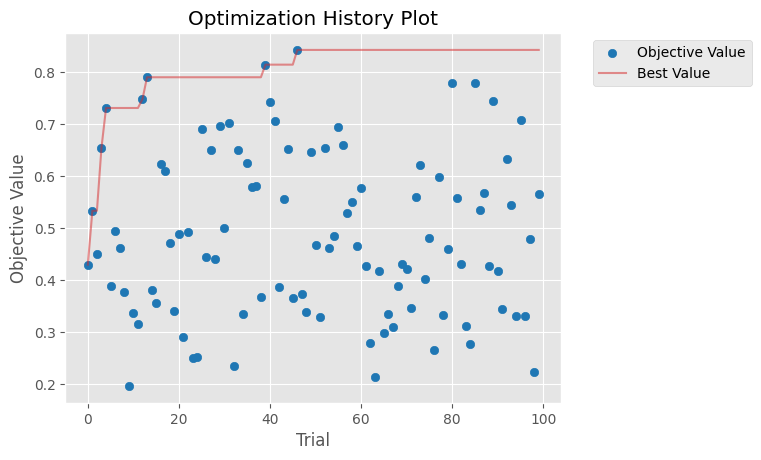

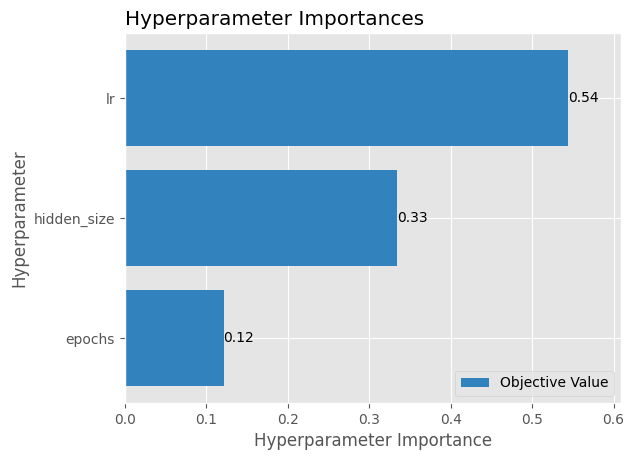

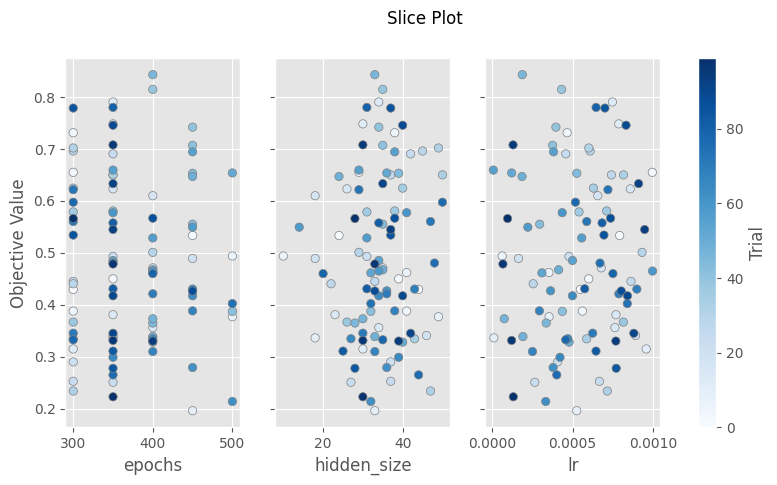

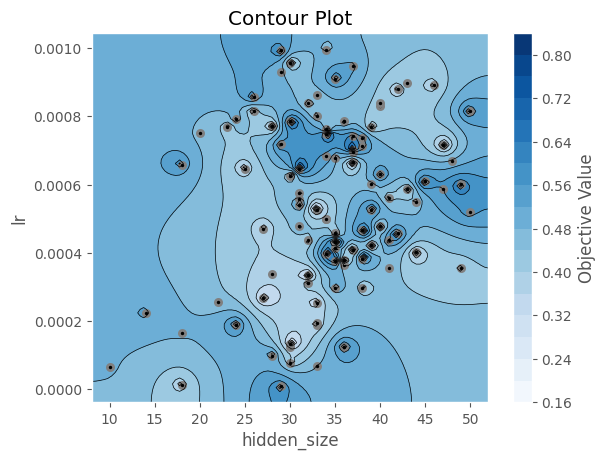

In [38]:
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_param_importances(study)
optuna.visualization.matplotlib.plot_slice(study)
optuna.visualization.matplotlib.plot_contour(study, ['lr', 'hidden_size'])

In [13]:
from torch_geometric.nn import GCNConv, SAGEConv, GINEConv, GATConv, BatchNorm, Linear
import torch

class GAT_GraphSVX(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads, dropout=0.3):
        super(GAT_GraphSVX, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout = dropout
        self.MLP_pre1 = torch.nn.Linear(in_channels, in_channels)
        self.MLP_pre2 = torch.nn.Linear(in_channels, in_channels)
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=dropout)
        self.conv3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat = False, dropout=dropout)
        self.MLP_post1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.MLP_post2 = torch.nn.Linear(hidden_channels, out_channels)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        self.return_attention_weights = False
    
    def set_return_attention_weights(self, return_attention_weights):
        if return_attention_weights == True or return_attention_weights == False:
            self.return_attention_weights = return_attention_weights
        else:
            raise ValueError('return_attention_weights must be either True or False')


    def forward(self, x, edge_index):
        # Pre processing layers
        x = self.MLP_pre1(x)
        x = self.MLP_pre2(x)
        
        # GNN layers
        x, attention_weights1 = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, attention_weights2 = self.conv2(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, attention_weights3 = self.conv3(x, edge_index, return_attention_weights=True)
        
        # Post processing layers
        x = self.MLP_post1(x)
        x = self.MLP_post2(x)
        
        # Activation function
        x = self.log_softmax(x) #<--- need to use NLLLoss
        
        if self.return_attention_weights:
            return x, attention_weights1, attention_weights2, attention_weights3
        else:
            return x
    
    # Adaption for Node Feature Vector (NFV) input
    def set_test_data(self, testdata):
        self.testdata = testdata
    
    def set_node_to_explain(self, node_to_explain):
        self.node_to_explain = node_to_explain
    
    def forward_NFVinput(self, node_feature_vec):
        print('Starting forward_LIME...')
        num_nodes = self.testdata.x.shape[0]
        
        node_feature_vec = node_feature_vec.reshape(-1,self.in_channels)
        num_samples = node_feature_vec.shape[0]
        out = torch.zeros((num_samples,2))
        print(f'Number of samples = {num_samples}')
        
        data_list = []
        
        print('Loading data...')
        for i in range(num_samples):
            new_graph = copy.deepcopy(self.testdata)
            new_graph.x[self.node_to_explain,:] = node_feature_vec[i,:]
            data_list.append(new_graph)
        print(f'number of graphs = {len(data_list)}')
        
        print('Loading data into a single batch...')
        #dataset = CustomDataset(data_list)
        batch = torch_geometric.data.Batch.from_data_list(data_list)
        
        print('Starting forward pass...')
        with torch.no_grad():
            out_tmp = self.forward(batch.x, batch.edge_index).exp()
        
        print(f'out_tmp.shape = {out_tmp.shape}')
        print('Extracting output...')
        for i in range(batch.num_graphs):
            out[i] = out_tmp[self.node_to_explain+i*num_nodes,:]
            
        print('Finished.')

        return out

In [14]:
def train_GAT_GraphSVX(hyperparameters = None, verbose = False):
    # Computing device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    print('Double check which dataset is being used.')
    
    # Data
    traindata = data.AmlsimDataset(node_file='data/simulation3/swedbank/train/nodes.csv', edge_file='data/simulation3/swedbank/train/edges.csv', node_features=True, node_labels=True).get_data()
    testdata = data.AmlsimDataset(node_file='data/simulation3/swedbank/test/nodes.csv', edge_file='data/simulation3/swedbank/test/edges.csv', node_features=True, node_labels=True).get_data()
    traindata = torch_geometric.transforms.ToUndirected()(traindata)
    testdata = torch_geometric.transforms.ToUndirected()(testdata)
    feature_names = ['sum','mean','median','std','max','min','in_degree','out_degree','n_unique_in','n_unique_out']
    target_names = ['not_sar','is_sar']
    
    # --- Add preprocessing here ---
    
    traindata = traindata.to(device)
    testdata = testdata.to(device)
    
    # Non-tunable hyperparameters
    in_channels = traindata.x.shape[1]
    out_channels = 2
    
    # Tunable hyperparamters
    hidden_channels = 10
    num_heads = 3
    dropout = 0.3
    lr = 0.005
    epochs = 400
    class_weights = [1, 3]
    
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    
    # Model
    model = GAT_GraphSVX(in_channels=in_channels,
                        hidden_channels=hidden_channels,
                        out_channels=out_channels,
                        num_heads=num_heads,
                        dropout=dropout)
    
    model = model.to(device)
    
    # Criterion and optimizer
    criterion = torch.nn.NLLLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Train model
    print(f'Starting training with {epochs} epochs.')
    # This model needs special input format, so we can't use the train_model function
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model.forward(traindata.x, traindata.edge_index)
        loss = criterion(out, traindata.y)
        loss.backward()
        optimizer.step()
        if verbose and ((epoch+1)%10 == 0 or epoch == epochs-1):
            model.eval()
            with torch.no_grad():
                out = model.forward(testdata.x, testdata.edge_index)
                loss = criterion(out, testdata.y)
                precision = precision_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
                recall = recall_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
                print(f'epoch: {epoch + 1}, loss: {loss:.4f}, precision: {precision:.4f}, recall: {recall:.4f}')
    print('Finished training.')
    
    return model, traindata, testdata, feature_names, target_names

In [15]:
model, traindata, testdata, feature_names, target_names = train_GAT_GraphSVX(verbose=True)

Using device: cuda
Double check which dataset is being used.
Starting training with 400 epochs.
epoch: 10, loss: 27.1826, precision: 0.0682, recall: 0.3770
epoch: 20, loss: 13.0339, precision: 0.1443, recall: 0.3885
epoch: 30, loss: 2.4645, precision: 0.1389, recall: 0.4345
epoch: 40, loss: 10.2796, precision: 0.0893, recall: 0.9954
epoch: 50, loss: 0.8300, precision: 0.0769, recall: 0.1931
epoch: 60, loss: 1.9467, precision: 0.0000, recall: 0.0000
epoch: 70, loss: 1.0454, precision: 0.1062, recall: 0.6782
epoch: 80, loss: 1.0321, precision: 0.0947, recall: 0.9586
epoch: 90, loss: 1.1073, precision: 0.0888, recall: 0.9632
epoch: 100, loss: 0.8257, precision: 0.0910, recall: 0.8437
epoch: 110, loss: 1.0332, precision: 0.0897, recall: 1.0000
epoch: 120, loss: 1.1550, precision: 0.0890, recall: 0.9816
epoch: 130, loss: 0.8288, precision: 0.0922, recall: 0.8414
epoch: 140, loss: 0.8739, precision: 0.0889, recall: 0.8575
epoch: 150, loss: 1.1634, precision: 0.0897, recall: 1.0000
epoch: 160